In [19]:
import numpy as np
import pandas as pd
import pickle
import random
import sys, time
from functions import production_function, regularise, wage_function, demand_function, innovate, generate_nested_matrix, visualize_multi_layer_trade_network, array_to_dataframe
from tradeutils import doAllTrades
from pricing import updatePricesAndConsume
from tqdm import tqdm

np.random.seed(1)

def convert_to_matrices(params, n_countries, n_products, default_value=0):
    alpha_matrix = np.zeros((n_countries, n_products))
    beta_matrix = np.zeros((n_countries, n_products))
    A_matrix = np.zeros((n_countries, n_products))

    for i in range(n_countries):
        for j in range(n_products):
            alpha_key = f'alpha-{i}-{j}'
            A_key = f'A-{i}-{j}'
            beta_key = f'beta-{i}-{j}'
            alpha_matrix[i, j] = params.get(alpha_key, default_value)
            beta_matrix[i, j] = params.get(beta_key, default_value)
            A_matrix[i, j] = params.get(A_key, default_value)

    return alpha_matrix, beta_matrix, A_matrix

# Example usage with the same params and assuming the missing keys
# alpha, beta, A = convert_to_matrices(params, n_countries, n_products)

def gulden_vectorised(case, n_countries, n_products, countries, products, citizens_per_nation, A, alpha, beta,  share, iterations=2000, Tr_time=1, trade_change=1, autarky_time=10000,pricing_algorithm='dgp', utility_algorithm='geometric',                         
                      wage_algorithm='marginal_product', csv=False, plot=False, shock=None, shock_time=10000,  cm_time=10000, d=0.000, innovation=False, innovation_time=10000, gamma=1, eta=0.01,weights=None, elasticities=None, sigma=None, c_names=countries, p_names=products):
    
    ## Citizen-level
    # Initialize prices for each good in each nation
    prices = np.ones((n_countries, n_products))
    prices_vec = np.ones((n_countries, n_products, iterations))

    # Initialize industry choices for labor and capital for each citizen in each nation
    labor_choices = [np.zeros(citizens, dtype=int) for citizens in citizens_per_nation]
    capital_choices = [np.zeros((citizens, 2), dtype=int) for citizens in citizens_per_nation]
    income = [np.zeros(citizens) for citizens in citizens_per_nation]

    domestic_income = np.zeros((n_countries, n_countries))
    foreign_income = np.zeros((n_countries, n_countries))

    # Allow capital choices to take both industry and nation if capital mobility is enabled
    for nation in range(n_countries):
        labor_choices[nation] = np.random.choice(range(n_products), citizens_per_nation[nation])
        capital_choices[nation][:, 0] = np.random.choice(range(n_products), citizens_per_nation[nation])
        capital_choices[nation][:, 1] = np.ones(citizens_per_nation[nation]) * nation

    ## Nation-level
    # Calculate wages and returns to capital for each industry in each nation
    L = np.zeros((n_countries, n_products))
    K = np.zeros((n_countries, n_products))
    Q = np.zeros((n_countries, n_products))
    W = np.zeros((n_countries, n_products))
    R = np.zeros((n_countries, n_products))
    D = np.zeros((n_countries, n_products))
    D1 = np.zeros((n_countries, n_products))
    S = np.zeros((n_countries, n_products))
    net_exports = np.zeros(S.shape, dtype=np.float128)

    tv = np.zeros((n_countries, n_countries, n_products))
    labor = np.zeros((n_countries, n_products, iterations))
    capital = np.zeros((n_countries, n_products, iterations))
    production = np.zeros((n_countries, n_products, iterations))
    demand = np.zeros((n_countries, n_products, iterations))
    supply = np.zeros((n_countries, n_products, iterations))
    net_exports_history = np.zeros((n_countries, n_products, iterations))
    trades_history = np.zeros((n_countries*n_products, n_countries, iterations))
    wage = np.zeros((n_countries, n_products, iterations))
    returns = np.zeros((n_countries, n_products, iterations))
    utility = np.zeros((n_countries, iterations))
    gdp_vec = np.zeros((n_countries, iterations))
    gnp_vec = np.zeros((n_countries, iterations))
    io_mat = np.zeros((n_countries, n_countries, n_products))

    try:
        if len(Tr_time) > 1:
            T0 = Tr_time[0]
            T1 = Tr_time[1]
    except:
        T0 = Tr_time
        T1 = 0

    for t in tqdm(range(iterations)):

        Tr = False
        cap_mobility = False

        if t >= T0 or (T1 > 0 and t >= T1):
            Tr = True

        if t >= autarky_time:
            if (T1 > 0 and t < T1):
                Tr = False

        if t > shock_time:
            A = shock

        if t >= cm_time:
            cap_mobility = True

        for nation in range(n_countries):
            # Loop over each nation in the simulation.

            # Initialize arrays to determine which citizens will change their labor or capital choices.
            should_change_labor = np.zeros(citizens_per_nation[nation])
            should_change_capital = np.zeros(citizens_per_nation[nation])

            # Citizen update
            # Re-assess labor and capital choices

            # Find the industry with the maximum wage in the current nation.
            max_wage_industry = np.argmax(W[nation, :])
            # For each citizen, generate a random event (1 or 0) with a probability of 0.004.
            event_occurs = np.random.binomial(1, 0.004, size=citizens_per_nation[nation])

            # Determine which citizens should change labor based on the random event and wage comparison.
            # wages need to be d% above and the event needs to be true
            should_change_labor = (event_occurs == 1) * (
                        W[nation, labor_choices[nation]] < W[nation, max_wage_industry] * (1 + d))

            # Update the labor choices of citizens who decided to change.
            labor_choices[nation][should_change_labor == 1] = max_wage_industry

            # If capital mobility is enabled (cap_mobility is True).
            if cap_mobility:
                # Determine the industry with the maximum return globally (across all nations).
                max_return_industry = np.unravel_index(np.argmax(R, axis=None), R.shape)
                # Determine which citizens change capital choice based on random event and returns comparison.
                should_change_capital = (event_occurs == 1) * (
                            R[capital_choices[nation][:, 1], capital_choices[nation][:, 0]] < R[max_return_industry] * (1 + d))
                # Update the capital choices of citizens who decided to change.
                capital_choices[nation][should_change_capital == 1] = (max_return_industry[1], max_return_industry[0])

            else:
                # If capital mobility is disabled, only consider the current nation for max returns.
                max_return_industry = np.argmax(R[nation, :])
                # Determine which citizens should change their capital choice based on the random event and returns comparison.
                should_change_capital = (event_occurs == 1) * (
                            R[nation, capital_choices[nation][:, 0]] < R[nation, max_return_industry] * (1 + d))
                # Update the capital choices of citizens who decided to change.
                capital_choices[nation][should_change_capital == 1] = (max_return_industry, nation)

            # Calculate the total income for the nation by summing wages and returns for each citizen
            income[nation] = sum(
                W[nation, labor_choices[nation]] + R[capital_choices[nation][:, 1], capital_choices[nation][:, 0]])

            # Create a mask to identify foreign investments (other nations) for each citizen
            foreign_investment_nations = capital_choices[nation][:, 1] != nation
            domestic_investment_nations = capital_choices[nation][:,1] == nation

            # Calculate foreign income based on foreign investments (in the current nation)
            foreign_investment_indices = capital_choices[nation][:, 0][foreign_investment_nations]
            foreign_investment_nations = capital_choices[nation][:, 1][foreign_investment_nations]

            domestic_investment_indices = capital_choices[nation][:, 0][domestic_investment_nations]
            domestic_investment_nations = capital_choices[nation][:, 1][domestic_investment_nations]

            foreign_income[nation, foreign_investment_nations] = np.sum(R[foreign_investment_nations, foreign_investment_indices])
            domestic_income[nation, domestic_investment_nations] = np.sum(W[nation, labor_choices[nation]]) + np.sum(R[domestic_investment_nations, domestic_investment_indices])


        for nation in range(n_countries):
            for industry in range(n_products):
                # Loop over each industry to update the labor, capital, and demand for the nation.

                # Initialize labor and demand for the industry.
                L[nation, industry] = 0

                # D[nation, industry] = income[nation] / (n_products * prices[nation, industry])
                # Demand for nation's goods = domestic demand + foreign demand
                D1[nation, industry] = (domestic_income[nation,nation]/ (n_products*prices[nation,industry])) + np.sum([foreign_income[otherNation, nation]/ (n_products* prices[nation, industry]) for otherNation in range(n_countries)])

                # Update demand for the industry.
               

                # Update the labor count in the industry.
                L[nation, industry] = sum(labor_choices[nation] == industry)

                ## should probably be moved OUT of the loop, or it will not wait for other
                ## citizens to make their choices
                K[nation, industry] = 0
                ## let's use a single call for now;  less code duplication matters more than small speed-up for debugging
                K[nation, industry] = sum(
                    ((capital_choices[c][i, 0] == industry) and (capital_choices[c][i, 1] == nation)) for c in
                    range(n_countries) for i in range(citizens_per_nation[c]))
                
                if K[nation, industry] < 1:
                    K[nation, industry] = 1

                # Compute the production, wages, and returns for the industry using some functions.

                Q[nation, industry] = production_function(A[nation, industry], L[nation, industry], K[nation, industry],
                                                          alpha[nation, industry], beta[nation, industry])
                
                W[nation, industry], R[nation, industry] = wage_function(A[nation, industry], L[nation, industry],
                                                                         K[nation, industry], alpha[nation, industry],
                                                                         beta[nation, industry],
                                                                         p=prices[nation, industry],
                                                                         algorithm=wage_algorithm,share=share[nation])
                S[nation, industry] = Q[nation, industry]

        # Trade update
        if Tr:
            tv, net_exports = doAllTrades(tv, S, prices, trade_change) 
            S = Q - net_exports
            io = array_to_dataframe(tv, (countries, countries, products))
            io = -io
            io[io<0] = 0
            for i in io.index.get_level_values(0).unique():
                io.loc[(i,slice(None)),i] = S[int(i),:]
            trades_history[:, :, t] = io.values
#             io.head()

#         net_exports_history[:, :, t] = net_exports
        

        # Update prices and Consume
        prices, UT = updatePricesAndConsume(prices, D1, S, pricing_algorithm, utility_algorithm,                                                           weights=weights, elasticities=elasticities, sigma=sigma)
        prices_vec[:, :, t] = prices
        utility[:, t] = UT
        gdp_vec[:, t] = income
        supply[:, :, t] = S
        demand[:,:, t] = D1
        labor[:,:,t] = L
        capital[:,:,t] = K
        production[:,:,t] = Q
        wage[:,:,t] = W
        returns[:,:,t] = R

    # variables to return:
    import pandas as pd
    io_mat = np.sum(trades_history, axis=2)
#     print(io_mat)
    io_df = pd.DataFrame(io_mat, index=io.index, columns=io.columns)
    io_df2 = io_df[~io_df.index.get_level_values(1).isin([0])]
    io_df2 = io_df2.reset_index()
    io_df2 = io_df2.rename(columns={io_df2.columns[0]:'Group',io_df2.columns[1]:'Sector'})
    io_df2 = io_df2.set_index(['Group', 'Sector'])
    io_df2 = io_df2.div(io_df2.sum(axis=1), axis=0)
#     total_exports=np.sum(net_exports_history, axis=2)
    # io = array_to_dataframe(trades, (countries, countries, products))
    # io = -io
    # io[io<0]=0
    # s = np.sum(supply, axis=2)
    # for i in io.index.get_level_values(0).unique():
    #     io.loc[(i,slice(None)),i] = s[int(i),:]

    # Save the results of Labor, Productions, Wages, and Returns to a csv file
    if csv:
        import pandas as pd
        for nation in range(n_countries):
            for industry in range(n_products):
                df = pd.DataFrame({'t': range(iterations),
                                   'labor': labor[nation, industry, :],
                                   'capital': capital[nation, industry, :],
                                   'production': production[nation, industry, :],
                                   'wages': wage[nation, industry, :],
                                   'returns': returns[nation, industry, :],
                                   'prices': prices_vec[nation, industry, :],
                                   'demand': demand[nation, industry, :],
                                   'utility': utility[nation, :]})
                df.to_csv('vectorised_{}_{}.csv'.format(countries[nation], products[industry]))
                
        # Save the 4-D array as a pickle file
        with open('trade.pickle', 'wb') as pickle_file:
            pickle.dump(trades_history, pickle_file)        

    # Plot the results
    if plot:
        import matplotlib.pyplot as plt
        variables = ['production', 'demand', 'traded', 'labor', 'capital', 'wages', 'prices', 'ROI', 'MRS']
        fig, ax = plt.subplots(2, 5, figsize=(25, 10))
        for nation in range(n_countries):
            for industry in range(n_products):
                ax[0, 0].plot(range(iterations), production[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[0, 0].set_title('Production')

                ax[1, 0].plot(range(iterations), prices_vec[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[1, 0].set_title('Prices')

                ax[0, 2].plot(range(iterations), demand[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[0, 2].set_title('Demand')

                ax[1, 2].plot(range(iterations), supply[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[1, 2].set_title('Supply')

                ax[0, 3].plot(range(iterations), labor[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[0, 3].set_title('Labor')

                ax[1, 3].plot(range(iterations), capital[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[1, 3].set_title('Capital')

                ax[0, 4].plot(range(iterations), wage[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[0, 4].set_title('Wages')

                ax[1, 4].plot(range(iterations), returns[nation, industry, :],
                              label='{}-{}'.format(c_names[nation], p_names[industry]))
                ax[1, 4].set_title('Returns')

            ax[0, 1].plot(range(iterations), gdp_vec[nation, :],
                          label='{}-{}'.format(c_names[nation], p_names[industry]))
            ax[0, 1].set_title('GDP')

            ax[1, 1].plot(range(iterations), utility[nation, :],
                          label='{}-{}'.format(c_names[nation], p_names[industry]))
            ax[1, 1].set_title('Utility')
            
            if T1 > 0:
                T0 = Tr_time[0]
                T1 = Tr_time[1]
                ax[0,0].axvline(x=T0, ls= '--', color='k')
                ax[1,0].axvline(x=T0, ls= '--', color='k')
                ax[0,1].axvline(x=T0, ls= '--', color='k')
                ax[1,1].axvline(x=T0, ls= '--', color='k')
                ax[0,2].axvline(x=T0, ls= '--', color='k')
                ax[1,2].axvline(x=T0, ls= '--', color='k')
                ax[0,3].axvline(x=T0, ls= '--', color='k')
                ax[1,3].axvline(x=T0, ls= '--', color='k')
                ax[0,4].axvline(x=T0, ls= '--', color='k')
                ax[1,4].axvline(x=T0, ls= '--', color='k')
            
                ax[0,0].axvline(x=T1, ls= '--', color='k')
                ax[1,0].axvline(x=T1, ls= '--', color='k')
                ax[0,1].axvline(x=T1, ls= '--', color='k')
                ax[1,1].axvline(x=T1, ls= '--', color='k')
                ax[0,2].axvline(x=T1, ls= '--', color='k')
                ax[1,2].axvline(x=T1, ls= '--', color='k')
                ax[0,3].axvline(x=T1, ls= '--', color='k')
                ax[1,3].axvline(x=T1, ls= '--', color='k')
                ax[0,4].axvline(x=T1, ls= '--', color='k')
                ax[1,4].axvline(x=T1, ls= '--', color='k')
                
            else:
                ax[0,0].axvline(x=T0, ls= '--', color='k')
                ax[1,0].axvline(x=T0, ls= '--', color='k')
                ax[0,1].axvline(x=T0, ls= '--', color='k')
                ax[1,1].axvline(x=T0, ls= '--', color='k')
                ax[0,2].axvline(x=T0, ls= '--', color='k')
                ax[1,2].axvline(x=T0, ls= '--', color='k')
                ax[0,3].axvline(x=T0, ls= '--', color='k')
                ax[1,3].axvline(x=T0, ls= '--', color='k')
                ax[0,4].axvline(x=T0, ls= '--', color='k')
                ax[1,4].axvline(x=T0, ls= '--', color='k')
                
                
            if t>shock_time:
                ax[0, 0].axvline(x=shock_time, ls= '--', color='k')
                ax[1, 0].axvline(x=shock_time, ls= '--', color='k')
                ax[0, 1].axvline(x=shock_time, ls= '--', color='k')
                ax[1, 1].axvline(x=shock_time, ls= '--', color='k')
                ax[0, 2].axvline(x=shock_time, ls= '--', color='k')
                ax[1, 2].axvline(x=shock_time, ls= '--', color='k')
                ax[0, 3].axvline(x=shock_time, ls= '--', color='k')
                ax[1, 3].axvline(x=shock_time, ls= '--', color='k')
                ax[0, 4].axvline(x=shock_time, ls= '--', color='k')
                ax[1, 4].axvline(x=shock_time, ls= '--', color='k')
            
            if t>cm_time:
                ax[0, 0].axvline(x=cm_time, ls= '--', color='k')
                ax[1, 0].axvline(x=cm_time, ls= '--', color='k')
                ax[0, 1].axvline(x=cm_time, ls= '--', color='k')
                ax[1, 1].axvline(x=cm_time, ls= '--', color='k')
                ax[0, 2].axvline(x=cm_time, ls= '--', color='k')
                ax[1, 2].axvline(x=cm_time, ls= '--', color='k')
                ax[0, 3].axvline(x=cm_time, ls= '--', color='k')
                ax[1, 3].axvline(x=cm_time, ls= '--', color='k')
                ax[0, 4].axvline(x=cm_time, ls= '--', color='k')
                ax[1, 4].axvline(x=cm_time, ls= '--', color='k')
            
                

        handles, labels = ax[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=n_countries, fontsize=15)
        plt.savefig('/rds/general/user/nk821/home/anaconda3/CCS/ABM/Gulden/vectorised_tests/plots/{}.png'.format(case))

    return Q, income, net_exports, io_df, io_df2



# Gulden Model - Samuelson Outsourcing Paradox


100%|██████████| 2000/2000 [00:08<00:00, 248.99it/s]


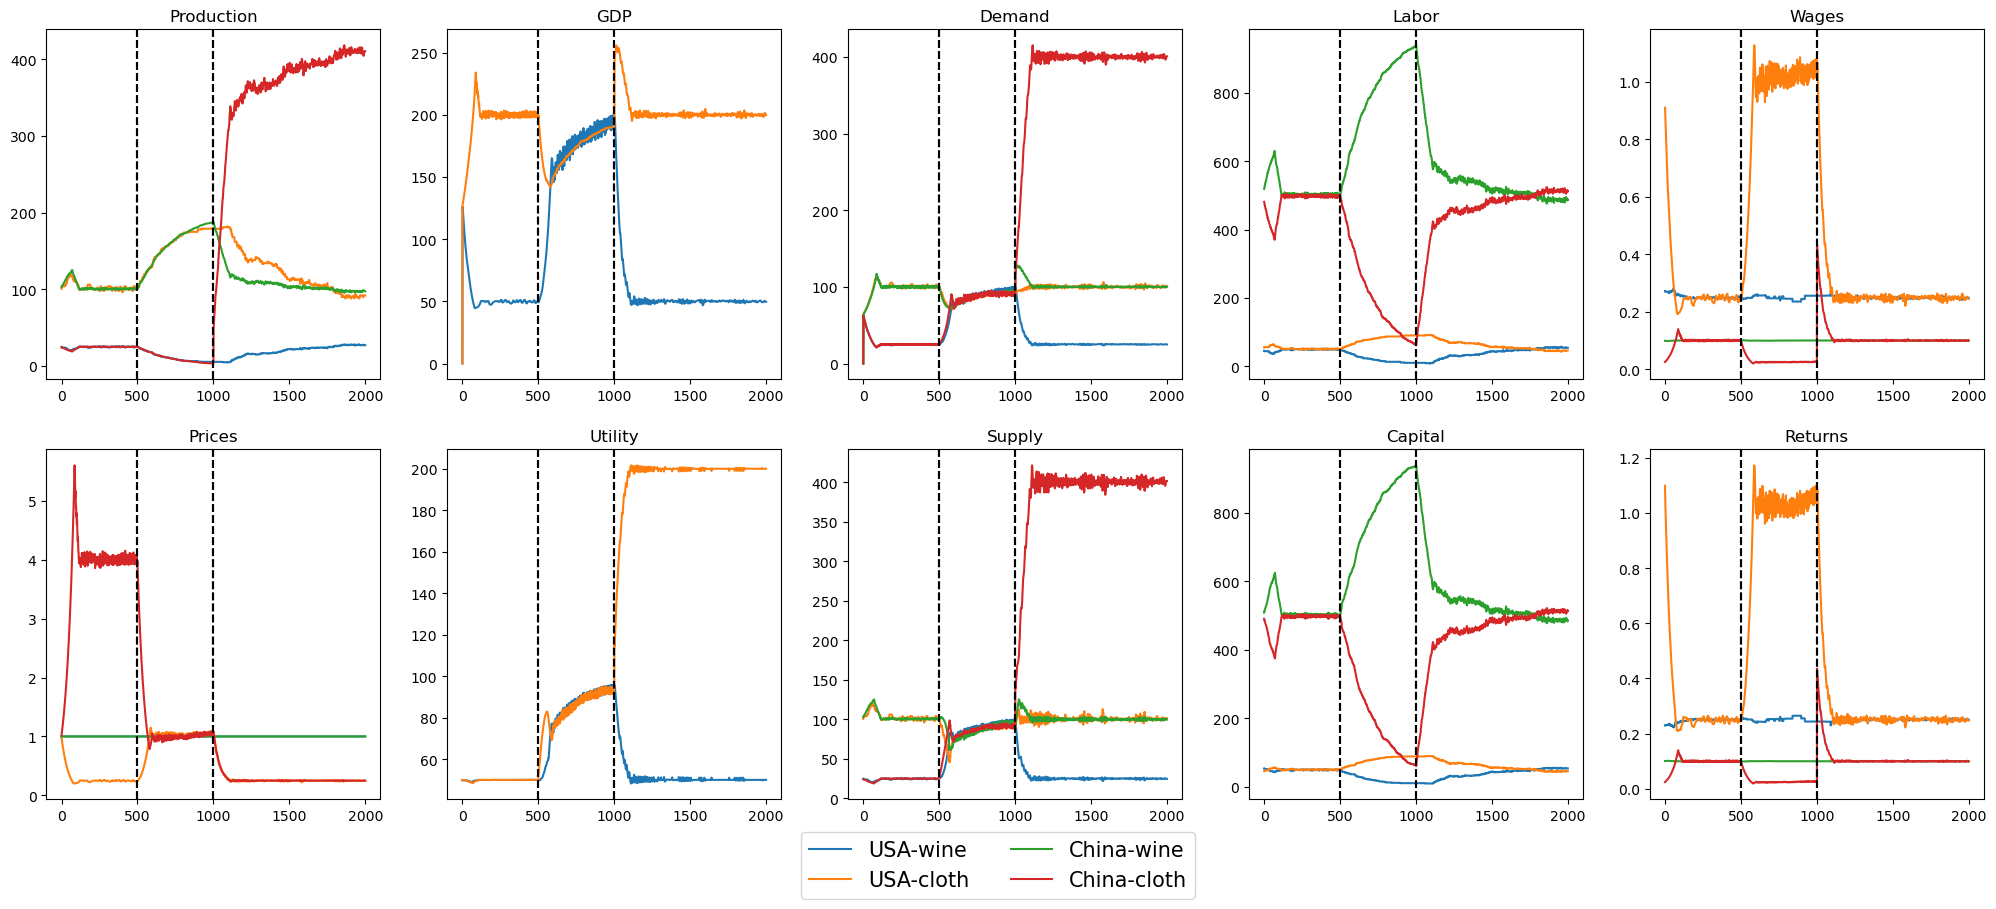

In [13]:
n_countries=2
n_products=2
countries = ['{i}'.format(i=i) for i in range(n_countries)]
products = ['{i}'.format(i=i) for i in range(n_products)]

A     = np.array([[0.5, 2.0],
                  [0.2, 0.05]])  # Total Factor Productivity

shock = np.array([[0.5, 2.0],
                  [0.2, 0.8]])  # Total Factor Productivity

share = np.ones(n_countries)

# Number of citizens in each nation
citizens_per_nation = [100, 1000]
alpha = np.ones((n_countries, n_products)) * 0.5
beta = np.ones((n_countries, n_products)) * 0.5

Q, income, net_exports, df1, df2 = gulden_vectorised('gulden_samuelson', n_countries, n_products, countries, products, citizens_per_nation, A, alpha, beta,  share, iterations=2000, Tr_time=500, trade_change=0.01, autarky_time=10000,pricing_algorithm='cpmu', utility_algorithm='geometric',                         
                                                     wage_algorithm='marginal_product', csv=False, plot=True, shock=shock, shock_time=1000,  cm_time=10000, d=0.000, innovation=False, innovation_time=10000, gamma=1, eta=0.01,weights=None, elasticities=None, sigma=None, c_names=['USA', 'China'], p_names=['wine','cloth'])


In [3]:
df2

,country,0,1
Group,Sector,,
0,1,0.697227,0.302773
1,1,0.004422,0.995578


# Gulden Model: Gomory-Boumol observations on returns to scale


100%|██████████| 3000/3000 [00:08<00:00, 350.98it/s]


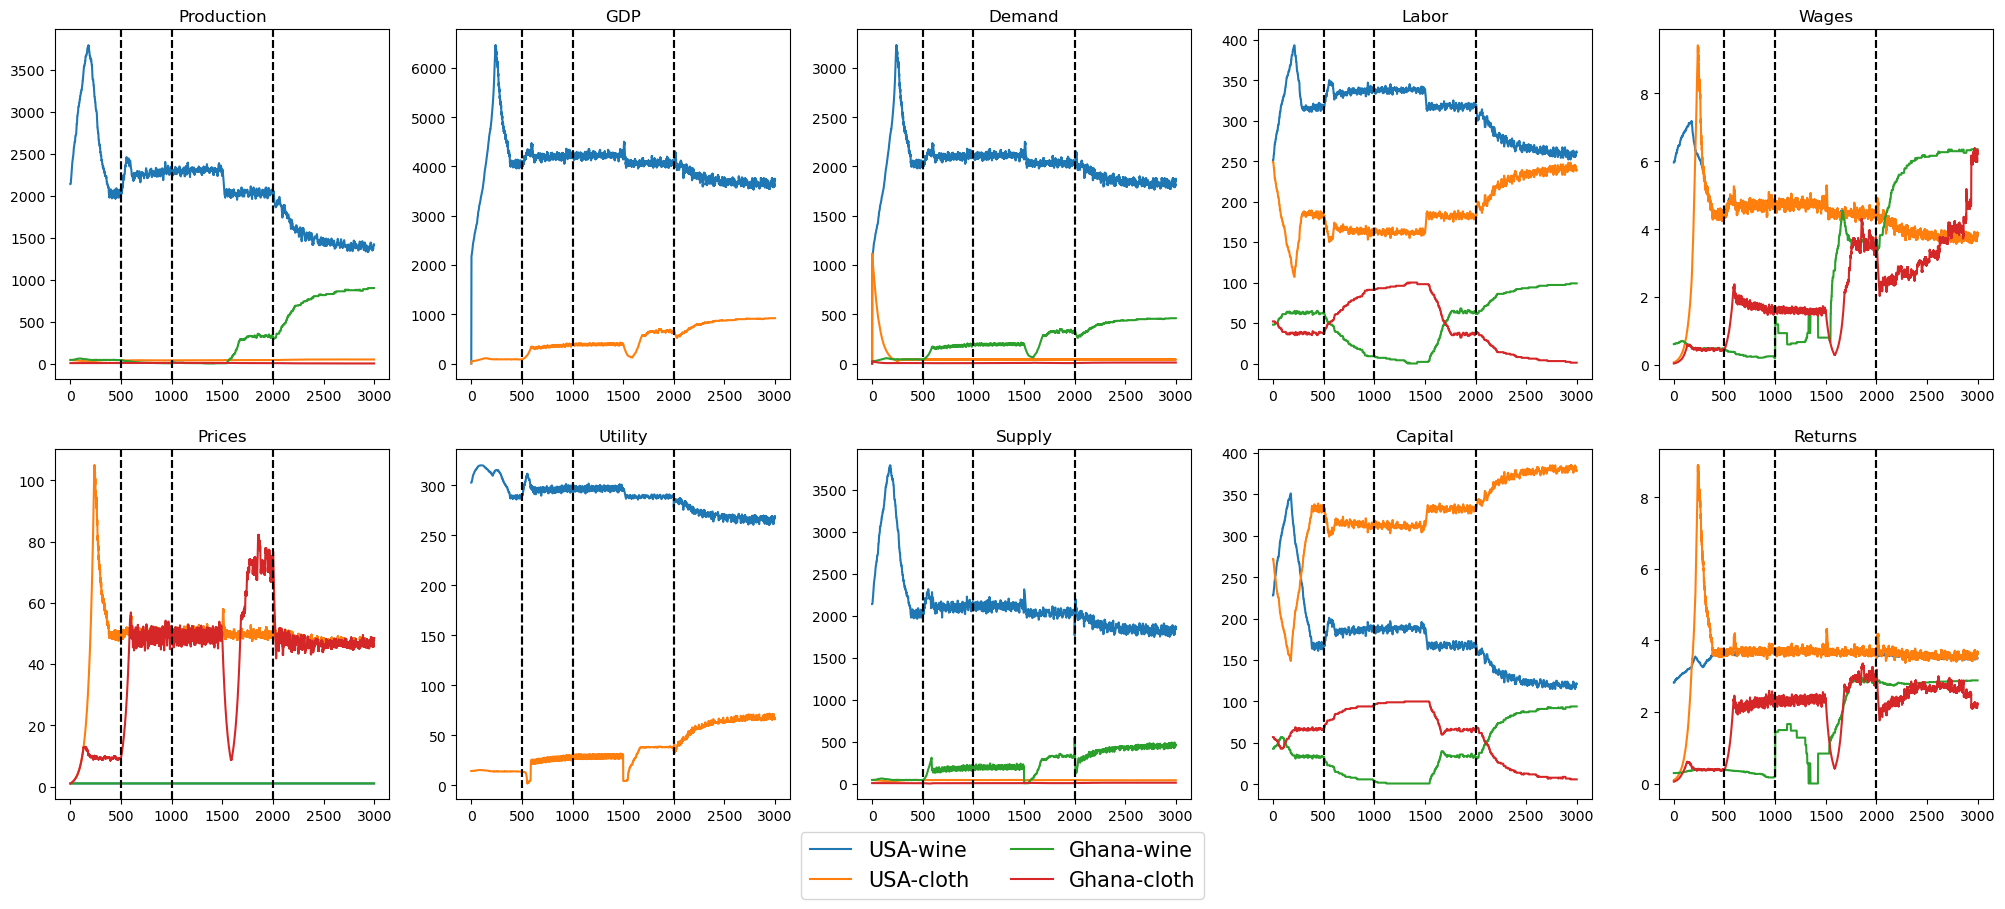

In [15]:
# Constants
case = '2x2_GB_model'
iterations = 1000
n_countries = 2
countries = ['{i}'.format(i=i) for i in range(n_countries)]
products = ['{i}'.format(i=i) for i in range(n_products)]

n_products = 2
alpha = np.array([[0.7, 0.4],
                  [0.7, 0.4]])  # output elasticity of labor

beta = np.array([[0.7, 0.4],
                 [0.7, 0.4]])  # output elasticity of capital

A = np.array([[1, .5],
              [0.2, 0.2]])  # Total Factor Productivity

shock = np.array([[1, .5],
                  [1.5, 0.2]])  # Total Factor Productivity

share = np.ones(n_countries)

# Number of citizens in each nation
citizens_per_nation = [500, 100]

Q, income, net_exports, df1, df2 = gulden_vectorised('Gomory-Boumol', n_countries, n_products, countries, products, citizens_per_nation, A, alpha, beta,  share, iterations=3000, Tr_time=[500,2000], trade_change=0.02, autarky_time=1500, pricing_algorithm='dgp', utility_algorithm='geometric',                        
                                                     wage_algorithm='marginal_product', csv=False, plot=True, shock=shock, shock_time=1000,  cm_time=10000, d=0.000, innovation=False, innovation_time=10000, gamma=1, eta=0.01,weights=None, elasticities=None, sigma=None, c_names=['USA','Ghana'], p_names=['wine','cloth'])


# Daly's Observations on Capital Mobility

100%|██████████| 3000/3000 [00:08<00:00, 350.24it/s]


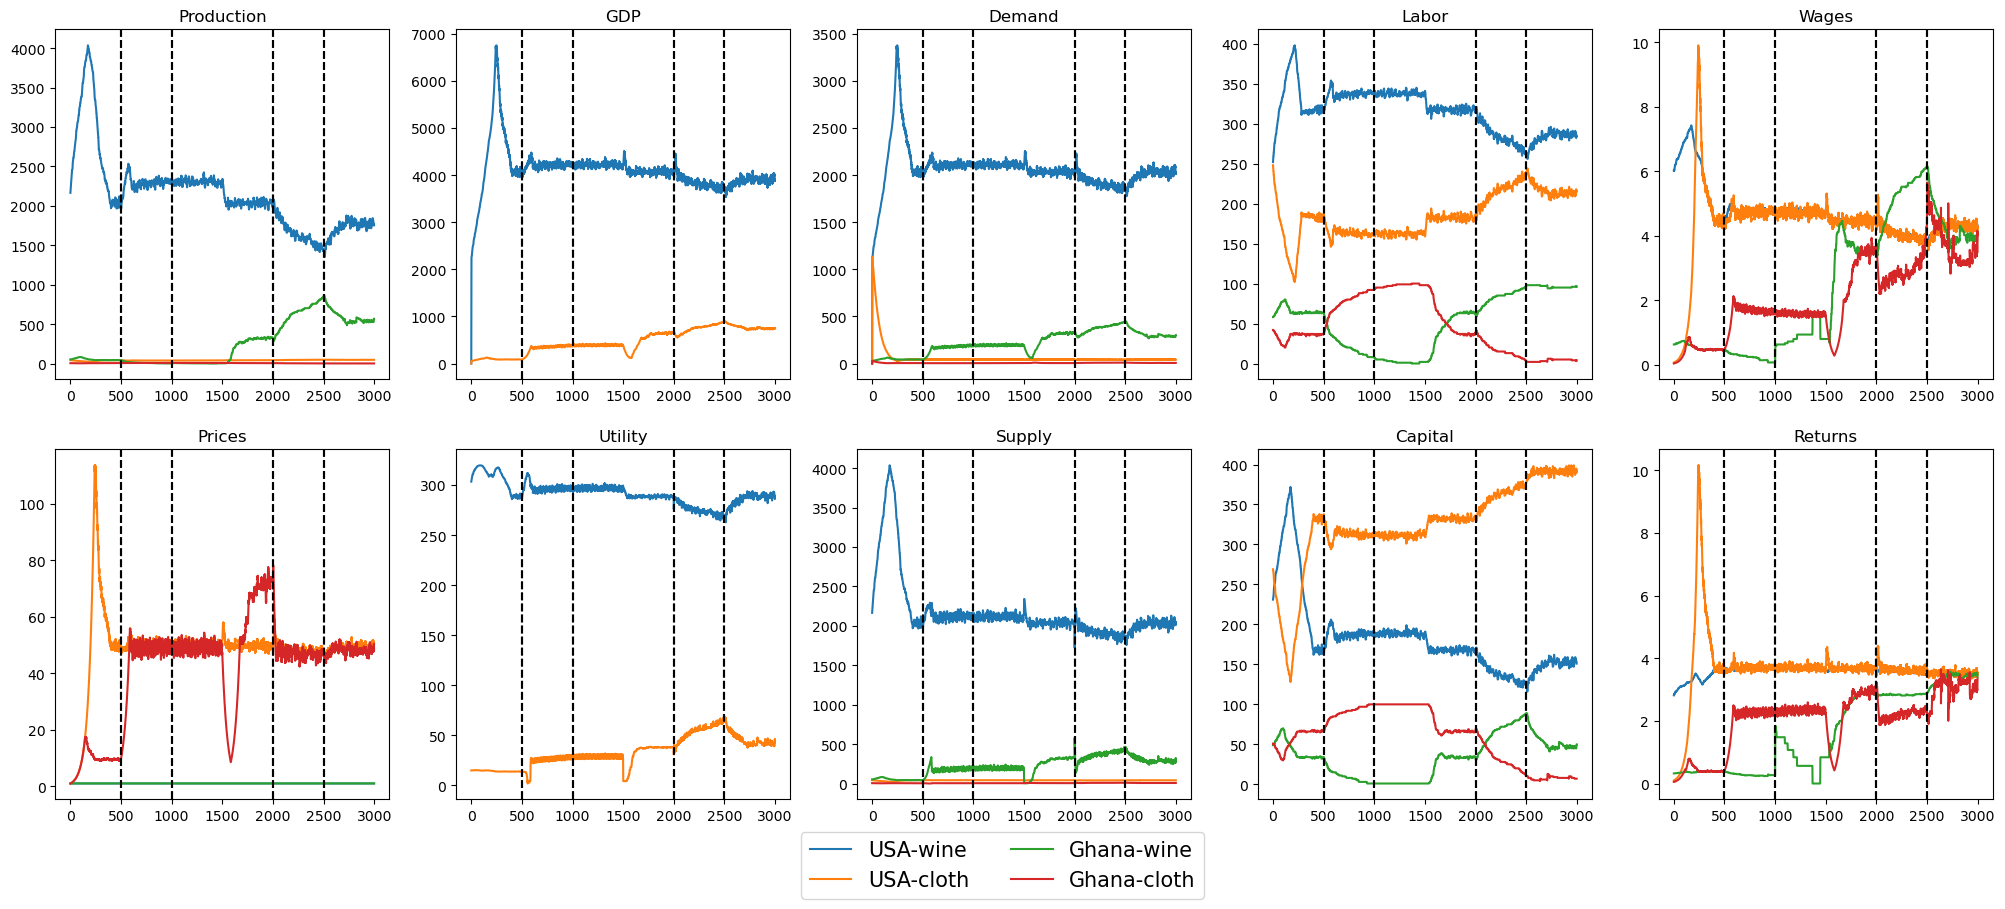

In [16]:
# Constants
case = 'capmob'
iterations = 1000
n_countries = 2
countries = ['{i}'.format(i=i) for i in range(n_countries)]
products = ['{i}'.format(i=i) for i in range(n_products)]

n_products = 2
alpha = np.array([[0.7, 0.4],
                  [0.7, 0.4]])  # output elasticity of labor

beta = np.array([[0.7, 0.4],
                 [0.7, 0.4]])  # output elasticity of capital

A = np.array([[1, .5],
              [0.2, 0.2]])  # Total Factor Productivity

shock = np.array([[1, .5],
                  [1.5, 0.2]])  # Total Factor Productivity

share = np.ones(n_countries)

# Number of citizens in each nation
citizens_per_nation = [500, 100]

Q, income, net_exports, df1, df2 = gulden_vectorised(case, n_countries, n_products, countries, products, citizens_per_nation, A, alpha, beta,  share, iterations=3000, Tr_time=[500,2000], trade_change=0.02, autarky_time=1500, pricing_algorithm='dgp', utility_algorithm='geometric',                        
                                                     wage_algorithm='marginal_product', csv=False, plot=True, shock=shock, shock_time=1000,  cm_time=2500, d=0.000, innovation=False, innovation_time=10000, gamma=1, eta=0.01,weights=None, elasticities=None, sigma=None, c_names=['USA', 'Ghana'], p_names=['wine','cloth'])


# 3-country scenario: Trade Scenario

# 3-country scenario: Capital Mobility: Indirect Impact of development

# n-country; n product scenario: Sensitivity to change in A, alpha, and beta

# Solution to regional trade network calibration:


In [22]:
from functions import convert_to_matrices
import pandas as pd
import numpy as np

A_opt = pd.read_csv('A.csv')
alpha_opt = pd.read_csv('alpha.csv')
beta_opt = pd.read_csv('beta.csv')

def dataframe_to_matrix(df):
    """
    Convert a dataframe with 'param' and 'value' columns to a 7x13 matrix.
    
    Parameters:
    - df: Pandas DataFrame with at least two columns: 'param' and 'value'.
          The 'param' column should contain strings in the format "A-row-col",
          indicating the position of the value in the matrix.
    
    Returns:
    - A 7x13 numpy matrix filled with values from the 'value' column of the dataframe.
    """
    # Extract row and column indices
    df[['temp', 'row', 'col']] = df['param'].str.split('-', expand=True)
    df['row'] = df['row'].astype(int)
    df['col'] = df['col'].astype(int)
    
    # Create an empty matrix of the desired size (7x13)
    matrix_size = (7, 13)
    matrix = np.zeros(matrix_size)
    
    # Fill the matrix with the values from the dataframe
    for index, row in df.iterrows():
        matrix[row['row'], row['col']] = row['value']
    
    return matrix

# Example usage
A = dataframe_to_matrix(A_opt)
alpha = dataframe_to_matrix(alpha_opt)
beta = dataframe_to_matrix(beta_opt)
n_countries=7
countries = ['{i}'.format(i=i) for i in range(n_countries)]
pop = [1000, 388, 208, 157, 808, 510, 271]

share = np.ones(n_countries)
n_products=13
products = ['{i}'.format(i=i) for i in range(n_products)]

Q, income, net_exports, io_df, io_df2 = gulden_vectorised('opt', n_countries=n_countries, n_products=n_products, countries=countries, products=products, 
                                                          citizens_per_nation=pop, A=A, alpha=alpha, beta=beta,  share=share, iterations=2000, 
                                                          Tr_time=1, trade_change=0.01, autarky_time=10000,
                                                          pricing_algorithm='cpmu', utility_algorithm='geometric',                         
                                                          wage_algorithm='marginal_product', csv=False, plot=False, 
                                                          shock=None, shock_time=10000,  cm_time=1, d=0.000, 
                                                          innovation=False, innovation_time=10000, gamma=1, eta=0.01,
                                                          weights=None, elasticities=None, sigma=None)


io_df2

100%|██████████| 2000/2000 [03:51<00:00,  8.66it/s]

[[3.06266782e+07 2.01048036e+07 4.04551047e+06 7.86536997e+06
  8.87754823e+06 1.18400653e+07 1.56706713e+07]
 [1.55756989e+07 3.94945759e+01 0.00000000e+00 2.53366288e+01
  4.24479532e+01 3.20416771e+01 1.76947742e+01]
 [1.74137970e+06 0.00000000e+00 3.43743164e+00 2.92017008e+01
  2.50364027e+01 1.87251016e+01 1.93306419e+01]
 [8.01094103e+06 0.00000000e+00 1.09334435e+03 4.28727838e+02
  4.60061217e+02 3.11964322e+02 2.83170610e+02]
 [1.88840115e+07 1.85511790e+03 1.98019407e+03 6.84865684e+02
  6.59364454e+02 0.00000000e+00 9.25117039e+02]
 [2.13730277e+07 2.04714214e+03 2.77329880e+03 0.00000000e+00
  9.19143303e+02 2.17840553e+03 8.68931437e+02]
 [7.02245134e+06 6.90462465e+03 6.15338452e+03 5.41485997e+03
  3.97089809e+03 1.01194609e+04 0.00000000e+00]
 [2.27904494e+06 1.38358262e+01 1.43181718e+00 1.39397576e+01
  4.04798135e+00 0.00000000e+00 0.00000000e+00]
 [8.47433959e+06 5.75245479e+06 2.40687933e+06 1.86574836e+06
  2.24314150e+06 3.25779122e+06 2.72874196e+06]
 [3.956428

country              0         1         2         3             4  \
Group Sector                                                         
0     1       0.999990  0.000003  0.000000  0.000002  2.725240e-06   
      2       0.999945  0.000000  0.000002  0.000017  1.437655e-05   
      3       0.999678  0.000000  0.000136  0.000054  5.741064e-05   
      4       0.999677  0.000098  0.000105  0.000036  3.490526e-05   
      5       0.999589  0.000096  0.000130  0.000000  4.298715e-05   
...                ...       ...       ...       ...           ...   
6     8       0.000005  0.000007  0.000006  0.000002  1.694130e-07   
      9       0.000044  0.000007  0.000007  0.000006  3.400924e-07   
      10      0.000010  0.000013  0.000006  0.000003  0.000000e+00   
      11      0.000586  0.000602  0.000004  0.000026  7.444889e-04   
      12      0.000000  0.000017  0.000005  0.000007  6.687192e-06   

country                  5         6  
Group Sector                          
0     1       2.057137e-06  0.000001  
      2       1.075244e-05  0.000011  
      3       3.892976e-05  0.000035  
      4       0.000000e+00  0.000049  
      5       1.018812e-04  0.000041  
...                    ...       ...  
6     8       1.850780e-09  0.999981  
      9       1.107993e-05  0.999924  
      10      3.881985e-06  0.999964  
      11      1.496520e-04  0.997889  
      12      6.136930e-06  0.999958  

[84 rows x 7 columns]